In [2]:
import numpy as np
import matplotlib.pyplot as plt

def centering_step(Q, p, A, b, t, v0, eps):
    """
    Newton's method for the centering step in the barrier method.

    Args:
        Q (ndarray): Quadratic term (n x n positive semi-definite matrix).
        p (ndarray): Linear term (n-dimensional vector).
        A (ndarray): Constraint matrix (m x n).
        b (ndarray): Constraint vector (m-dimensional vector).
        t (float): Barrier method parameter.
        v0 (ndarray): Initial feasible point (n-dimensional vector).
        eps (float): Target precision for Newton's method.

    Returns:
        list: Sequence of variable iterates (v_i) until convergence.
    """
    def barrier_function_gradient(v):
        """
        Gradient of the barrier function.
        """
        g = t * (Q @ v + p) + np.sum(
            (A.T / (b - A @ v)), axis=1
        ) 
        return g

    def barrier_function_hessian(v):
        """
        Hessian of the barrier function.
        """
        H = t * Q
        for i in range(len(b)):
            ai = A[i, :]
            H += np.outer(ai, ai) / (b[i] - ai @ v) ** 2
        return H

    def compute_step_size(v, delta_v):
        """
        Backtracking line search to find the step size.
        """
        alpha = 0.1  # Parameter for sufficient decrease condition
        beta = 0.7  # Reduction factor
        t = 1 # Starting t
        while True:
            # Check feasibility of v + t * delta_v
            if np.any(A @ (v + t * delta_v) >= b):
                t *= beta
                continue
            # Check sufficient decrease condition
            lhs = barrier_function(v + t * delta_v)
            rhs = barrier_function(v) + alpha * t * np.dot(barrier_function_gradient(v), delta_v)
            if lhs < rhs: #stopping critterion
                break
            t *= beta
        return t

    def barrier_function(v):
        """
        Barrier objective function.
        """
        barrier_term = -np.sum(np.log(b - A @ v))
        return t * (0.5 * v.T @ Q @ v + p.T @ v) + barrier_term

    v = v0
    sequence = [v]
    while True:
        grad = barrier_function_gradient(v)
        hess = barrier_function_hessian(v)
        delta_v = -np.linalg.solve(hess, grad)  # Newton direction

        # Stopping criterion
        if np.linalg.norm(delta_v) <= eps:
            break

        # Line search to find step size
        step_size = compute_step_size(v, delta_v)
        v = v + step_size * delta_v
        sequence.append(v)

    return sequence


In [3]:
def barr_method(Q, p, A, b, v0, eps, mu=10):
    """
    Barrier method to solve the QP problem.

    Args:
        Q (ndarray): Quadratic term (n x n positive semi-definite matrix).
        p (ndarray): Linear term (n-dimensional vector).
        A (ndarray): Constraint matrix (m x n).
        b (ndarray): Constraint vector (m-dimensional vector).
        v0 (ndarray): Initial feasible point (n-dimensional vector).
        eps (float): Target precision for the overall barrier method.
        mu (float): Scaling factor for the barrier parameter t.

    Returns:
        list: Sequence of variable iterates (v_i) until convergence.
    """
    def objective_function(v):
        """
        Objective function of the original QP problem.
        """
        return 0.5 * v.T @ Q @ v + p.T @ v

    m = len(b)  # Number of constraints
    t = 1  # Initial barrier parameter
    v = v0
    sequence = [v]

    while True:
        # Solve the centering step for the current t
        centering_sequence = centering_step(Q, p, A, b, t, v, eps)
        v = centering_sequence[-1]  # Take the final value from centering step
        sequence.extend(centering_sequence)

        # Check duality gap
        gap = m / t
        if gap < eps:
            break

        # Increase the barrier parameter
        t *= mu

    return sequence


Running barrier method with mu = 2
Running barrier method with mu = 15
Running barrier method with mu = 50
Running barrier method with mu = 100


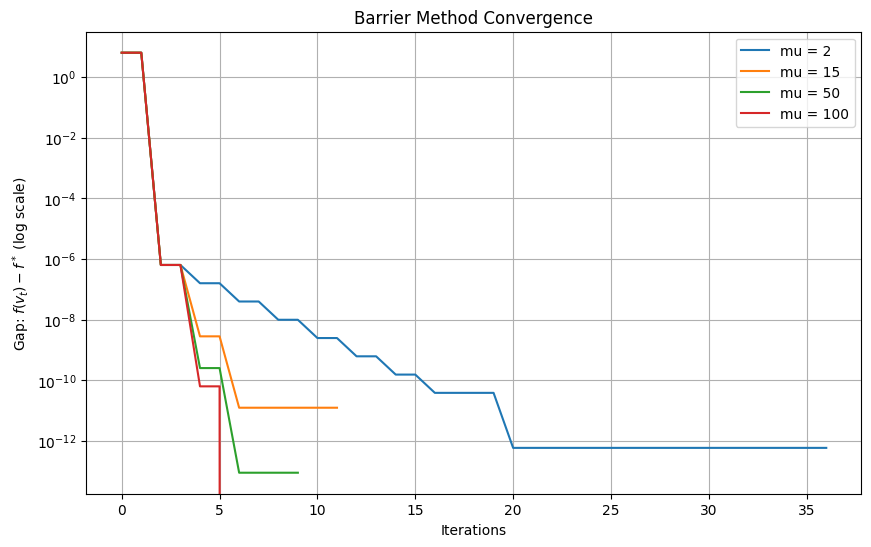

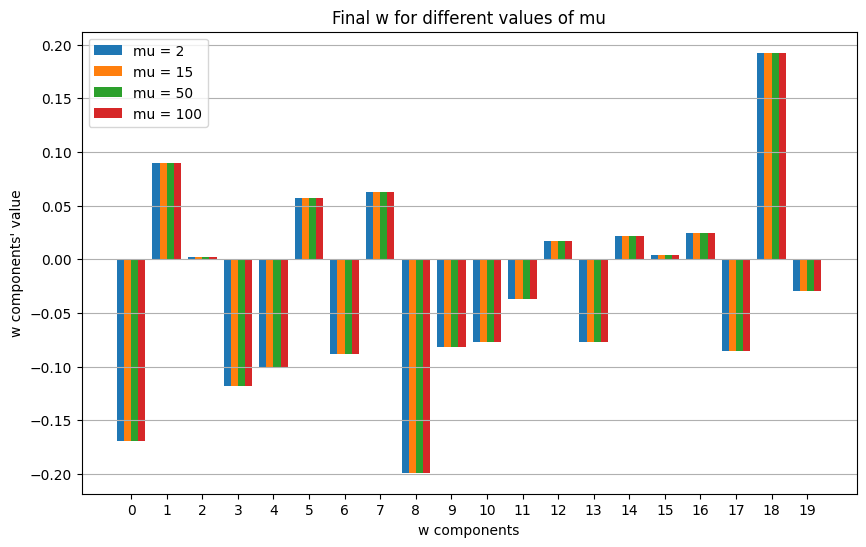

In [ ]:
# Random data
np.random.seed(42)
n, d = 100, 20  # Number of samples and features
X = np.random.randn(n, d)
y = np.random.randn(n)
lambda_val = 10

# Problems parameters
Q = X.T @ X
p = -X.T @ y
A = np.vstack([np.eye(d), -np.eye(d)])
b = np.hstack([lambda_val * np.ones(d), lambda_val * np.ones(d)])

# Initialization
v0 = np.zeros(d)  # Initial w is zero (feasible)
eps = 1e-6  # Precision criterion

# Barrier method with different mu values
mu_values = [2, 15, 50, 100]
results = {}

for mu in mu_values:
    print(f"Running barrier method with mu = {mu}")
    sequence = barr_method(Q, p, A, b, v0, eps, mu)
    results[mu] = sequence

# Compute f(v_t) for each iteration
def objective_function(v):
    return 0.5 * v.T @ Q @ v + p.T @ v

# Use the best final value found for f*
f_star = min(objective_function(sequence[-1]) for sequence in results.values())

# Plotting
plt.figure(figsize=(10, 6))
for mu, sequence in results.items():
    f_values = [objective_function(v) for v in sequence]
    gap = [f - f_star for f in f_values]
    plt.semilogy(gap, label=f"mu = {mu}")

plt.xlabel("Iterations")
plt.ylabel("Gap: $f(v_t) - f^*$ (log scale)")
plt.title("Barrier Method Convergence")
plt.legend()
plt.grid(True)
plt.show()


final_solutions = {}

for mu, sequence in results.items():
    final_solutions[mu] = sequence[-1]  # Store the last iterate (final w)

# Visualize w for each mu
plt.figure(figsize=(10, 6))
bar_width = 0.2  # Width of each bar group

indices = np.arange(len(final_solutions[2]))  # Indices of w (0, 1, ..., d-1)
for i, (mu, w_star) in enumerate(final_solutions.items()):
    plt.bar(indices + i * bar_width, w_star, bar_width, label=f"mu = {mu}")

# Labels and title
plt.xlabel("w components")
plt.ylabel("w components' value")
plt.title("Final w for different values of mu")
plt.xticks(indices + bar_width * (len(final_solutions) - 1) / 2, indices)  # Center ticks
plt.legend()
plt.grid(axis="y")
plt.show()